# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K
from tqdm.keras import TqdmCallback
from tensorflow.keras import optimizers

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else: 
    print("Using GPU to train")
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction, plot_learning_curves
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(f"Tensorflow version: {tf.__version__}, GPUs: {tf.config.list_physical_devices('GPU')}")

E0000 00:00:1762265642.713742   58600 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762265642.720386   58600 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762265642.736596   58600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762265642.736628   58600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762265642.736630   58600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762265642.736631   58600 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
Tensorflow version: 2.19.1, GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [3]:
#conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
#conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# DATA FROM VIET

## Load dataset

In [4]:
dataset_path = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"

df_raw = []

for csv_file in sorted(glob.glob(f"{dataset_path}/*")):
    print(f"Working on {csv_file}")
    df_station = pd.read_csv(csv_file)
    df_station["station"] = int(os.path.splitext(os.path.basename(csv_file))[0])
    df_raw.append(df_station)
df_raw = pd.concat(df_raw, axis=0)

# Lowercase columns name
df_raw.columns = df_raw.columns.map(lambda col: col.lower().strip())

# Set time index
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_raw.set_index("date", inplace=True)

# Drop columns
features_to_use = ["pm25_quantrac", "tsp_quantrac", "station"]
df_raw = df_raw.loc[:, features_to_use]

df_raw

Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/211.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/212.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/213.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/214.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/215.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/216.csv


,pm25_quantrac,tsp_quantrac,station
date,,,
2021-02-23 21:00:00,15.604762,32.935714,211
2021-02-23 22:00:00,14.594118,30.932353,211
2021-02-23 23:00:00,13.436667,27.645000,211
2021-02-24 00:00:00,12.365000,24.380000,211
2021-02-24 01:00:00,11.636667,22.521667,211
...,...,...,...
2022-12-31 19:00:00,41.450000,107.451667,216
2022-12-31 20:00:00,50.530000,126.168333,216
2022-12-31 21:00:00,55.055000,139.688333,216


## Data preparation

### Drop missing

In [5]:
df = []
for station in sorted(df_raw["station"].unique()):
    df_station = df_raw[df_raw["station"] == station]
    df.append(df_station.dropna())
df = pd.concat(df, axis=0)
df

,pm25_quantrac,tsp_quantrac,station
date,,,
2021-02-23 21:00:00,15.604762,32.935714,211
2021-02-23 22:00:00,14.594118,30.932353,211
2021-02-23 23:00:00,13.436667,27.645000,211
2021-02-24 00:00:00,12.365000,24.380000,211
2021-02-24 01:00:00,11.636667,22.521667,211
...,...,...,...
2022-12-31 19:00:00,41.450000,107.451667,216
2022-12-31 20:00:00,50.530000,126.168333,216
2022-12-31 21:00:00,55.055000,139.688333,216


### Feature engineering

In [6]:
# Apply sin/cos to hour
k = 24
df["sintime"] = np.sin(2 * np.pi * (df.index.hour / k))
df["costime"] = np.cos(2 * np.pi * (df.index.hour / k))

# Convert station to one-hot vector
onehot = OneHotEncoder(sparse_output=False)
onehot_encoded_location = pd.DataFrame(onehot.fit_transform(df[["station"]]), columns=df["station"].unique(), index=df.index)
df = pd.concat([df, onehot_encoded_location], axis=1)
df = df.drop(columns=["station"])
df

,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-02-23 21:00:00,15.604762,32.935714,-0.707107,0.707107,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 22:00:00,14.594118,30.932353,-0.500000,0.866025,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 23:00:00,13.436667,27.645000,-0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 00:00:00,12.365000,24.380000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 01:00:00,11.636667,22.521667,0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,41.450000,107.451667,-0.965926,0.258819,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 20:00:00,50.530000,126.168333,-0.866025,0.500000,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 21:00:00,55.055000,139.688333,-0.707107,0.707107,0.0,0.0,0.0,0.0,0.0,1.0


### Scale

In [7]:
df_scaled = copy.deepcopy(df)

# Scale features
features_to_scale = ["tsp_quantrac"]
for f in features_to_scale:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[f]])
    df_scaled[f] = scaled_data

# Scale label
label = "pm25_quantrac"
label_scaler = MinMaxScaler()
df_scaled[label] = label_scaler.fit_transform(df[[label]])

df_scaled

,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-02-23 21:00:00,0.096032,0.091311,-0.707107,0.707107,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 22:00:00,0.089813,0.085757,-0.500000,0.866025,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 23:00:00,0.082690,0.076643,-0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 00:00:00,0.076095,0.067591,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 01:00:00,0.071612,0.062439,0.258819,0.965926,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.255085,0.297899,-0.965926,0.258819,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 20:00:00,0.310963,0.349789,-0.866025,0.500000,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 21:00:00,0.338810,0.387272,-0.707107,0.707107,0.0,0.0,0.0,0.0,0.0,1.0


### Train test split

In [8]:
splitter = round(0.8 * len(df_scaled))
train_data = df_scaled.iloc[:splitter]
test_data = df_scaled.iloc[splitter:]

display(train_data)
display(test_data)

,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-02-23 21:00:00,0.096032,0.091311,-0.707107,7.071068e-01,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 22:00:00,0.089813,0.085757,-0.500000,8.660254e-01,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-23 23:00:00,0.082690,0.076643,-0.258819,9.659258e-01,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 00:00:00,0.076095,0.067591,0.000000,1.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0
2021-02-24 01:00:00,0.071612,0.062439,0.258819,9.659258e-01,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-21 06:00:00,0.059110,0.052214,1.000000,6.123234e-17,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 07:00:00,0.065058,0.058590,0.965926,-2.588190e-01,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 08:00:00,0.067930,0.060540,0.866025,-5.000000e-01,0.0,0.0,0.0,0.0,0.0,1.0


,pm25_quantrac,tsp_quantrac,sintime,costime,211,212,213,214,215,216
date,,,,,,,,,,
2021-09-21 11:00:00,0.065315,0.057731,2.588190e-01,-0.965926,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 12:00:00,0.059551,0.050703,1.224647e-16,-1.000000,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 13:00:00,0.058597,0.048018,-2.588190e-01,-0.965926,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 14:00:00,0.053520,0.039493,-5.000000e-01,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0
2021-09-21 15:00:00,0.064546,0.053170,-7.071068e-01,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.255085,0.297899,-9.659258e-01,0.258819,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 20:00:00,0.310963,0.349789,-8.660254e-01,0.500000,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-31 21:00:00,0.338810,0.387272,-7.071068e-01,0.707107,0.0,0.0,0.0,0.0,0.0,1.0


## Prediction

### Model paramaters

In [9]:
n_past = 168
n_future = 4
n_label = 1
latent_dim = 32

epochs = 200
batch_size = 128

In [10]:
# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Reframe data

In [11]:
# Function to reframe data
def reframe(data, n_past, n_future, n_shifted=0):
    m = np.arange(0, len(data) - n_past - n_future - n_shifted + 1)
    X = np.array([data.iloc[i:(i + n_past), :] for i in m])
    label_col_index = 0
    y = np.expand_dims(np.array([data.iloc[(i + n_shifted + n_past):(i + n_shifted + n_past + n_future), label_col_index] for i in m]), -1)
    return X, y

X_train, y_train = reframe(train_data, n_past, n_future)
X_test, y_test = reframe(test_data, n_past, n_future)

X_train_shifted_1, y_train_shifted_1 = reframe(train_data, n_past, n_future, 1)
X_test_shifted_1, y_test_shifted_1 = reframe(test_data, n_past, n_future, 1)
print(X_train_shifted_1.shape, y_train_shifted_1.shape, X_test_shifted_1.shape, y_test_shifted_1.shape)

X_train_shifted_2, y_train_shifted_2 = reframe(train_data, n_past, n_future, 2)
X_test_shifted_2, y_test_shifted_2 = reframe(test_data, n_past, n_future, 2)
print(X_train_shifted_2.shape, y_train_shifted_2.shape, X_test_shifted_2.shape, y_test_shifted_2.shape)

X_train_shifted_3, y_train_shifted_3 = reframe(train_data, n_past, n_future, 3)
X_test_shifted_3, y_test_shifted_3 = reframe(test_data, n_past, n_future, 3)
print(X_train_shifted_3.shape, y_train_shifted_3.shape, X_test_shifted_3.shape, y_test_shifted_3.shape)

X_train_shifted_4, y_train_shifted_4 = reframe(train_data, n_past, n_future, 4)
X_test_shifted_4, y_test_shifted_4 = reframe(test_data, n_past, n_future, 4)
print(X_train_shifted_4.shape, y_train_shifted_4.shape, X_test_shifted_4.shape, y_test_shifted_4.shape)

(39766, 168, 10) (39766, 4, 1) (9813, 168, 10) (9813, 4, 1)
(39765, 168, 10) (39765, 4, 1) (9812, 168, 10) (9812, 4, 1)
(39764, 168, 10) (39764, 4, 1) (9811, 168, 10) (9811, 4, 1)
(39763, 168, 10) (39763, 4, 1) (9810, 168, 10) (9810, 4, 1)


### LSTM-Seq2Seq

In [12]:
def define_lstms2s_model(n_past, n_future, n_features, n_label, name="model"):
    # Encoder layers
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_lstm_1 = LSTM(128, return_sequences=True, activation="relu")(encoder_inputs)
    encoder_lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu", dropout=0.2)(encoder_lstm_1)
    encoder_dense = Dense(latent_dim)(encoder_lstm_2)
    # Repeat layer
    decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
    # Decoder layers
    decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
    decoder_lstm_2 = LSTM(128, return_sequences=True, activation="relu", dropout=0.2)(decoder_lstm_1)
    decoder_outputs = TimeDistributed(Dense(n_label))(decoder_lstm_2)

    # Compile the model
    model = Model(encoder_inputs, decoder_outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    display(model.summary())
    return model

#### No shift

I0000 00:00:1762265708.286943   58600 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37057 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


Model: "lstms2s_no_shift"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 168, 128)  │     71,168 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 64),      │     49,408 │ lstm[0][0]        │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 4, 32)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 4, 64)     │     24,832 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 4, 128)    │     98,816 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 1)      │        129 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200


I0000 00:00:1762265714.842101   58680 service.cc:152] XLA service 0x60a06fa45c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762265714.842136   58680 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1762265716.016992   58680 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/249 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0223   

I0000 00:00:1762265733.024083   58680 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: nan - val_loss: nan
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: nan - val_loss: nan
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: nan - val_loss: nan
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: nan - val_loss: nan
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


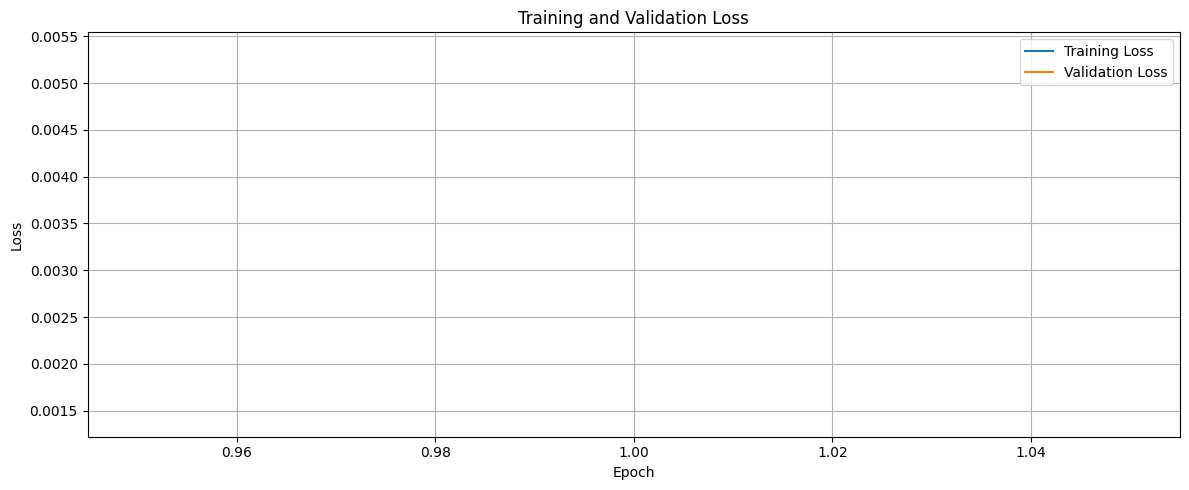

307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Day = 0
mae: 6.3815931175442575
mse: 84.66613865106078
rmse: 9.20142046920261
r2: -143.81981443554062
mape: 0.42080055535242894
mnbe: -21.742459028117615
r_coeff: [0.23234442]


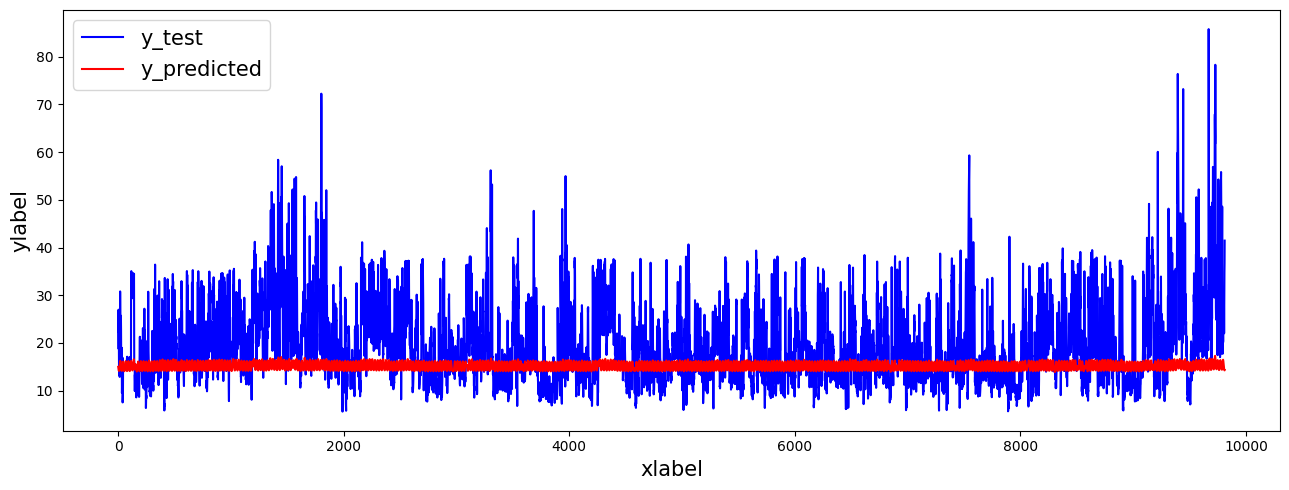

Day = 1
mae: 6.218006730174561
mse: 79.65481245357996
rmse: 8.924954479076067
r2: -128.27908822265235
mape: 0.3933429368041851
mnbe: -18.402011630076597
r_coeff: [0.23144771]


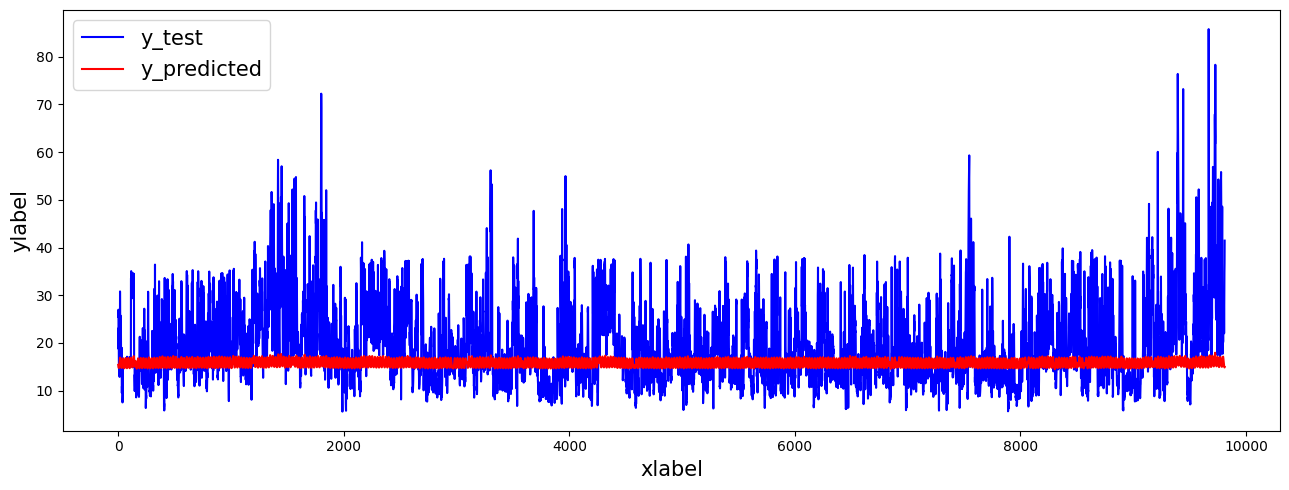

Day = 2
mae: 6.35909844165372
mse: 84.05166650275925
rmse: 9.167969595431654
r2: -182.50027071780806
mape: 0.4164985159516053
mnbe: -21.169626467022066
r_coeff: [0.22546548]


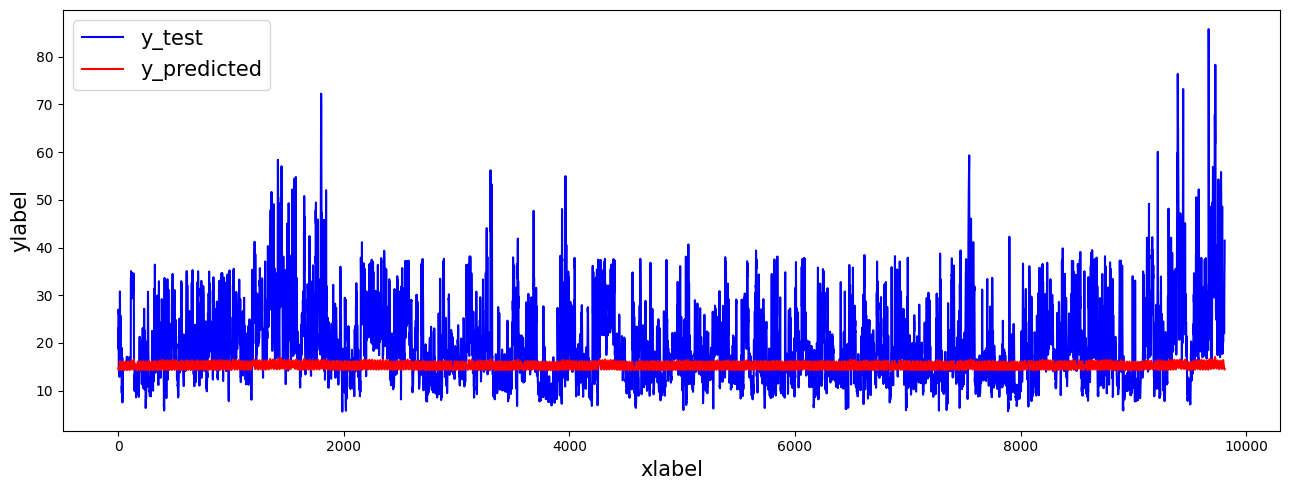

Day = 3
mae: 6.587103875867355
mse: 90.38701796375301
rmse: 9.507208736729883
r2: -303.5388965795646
mape: 0.45162163647850057
mnbe: -24.66218710092506
r_coeff: [0.21942056]


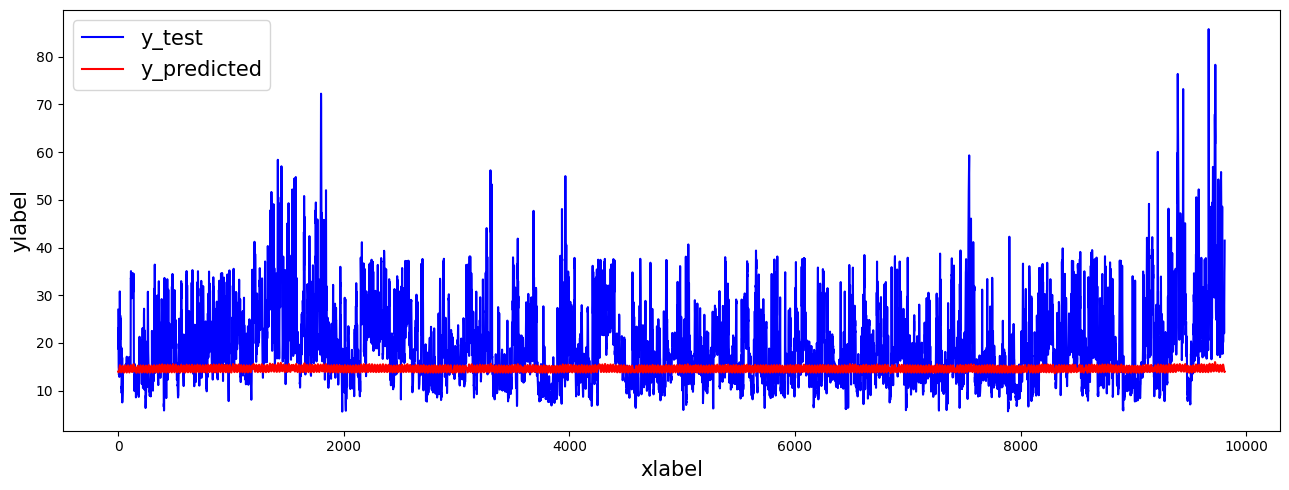

In [13]:
lstms2s = define_lstms2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], "lstms2s_no_shift")

history = lstms2s.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2s.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

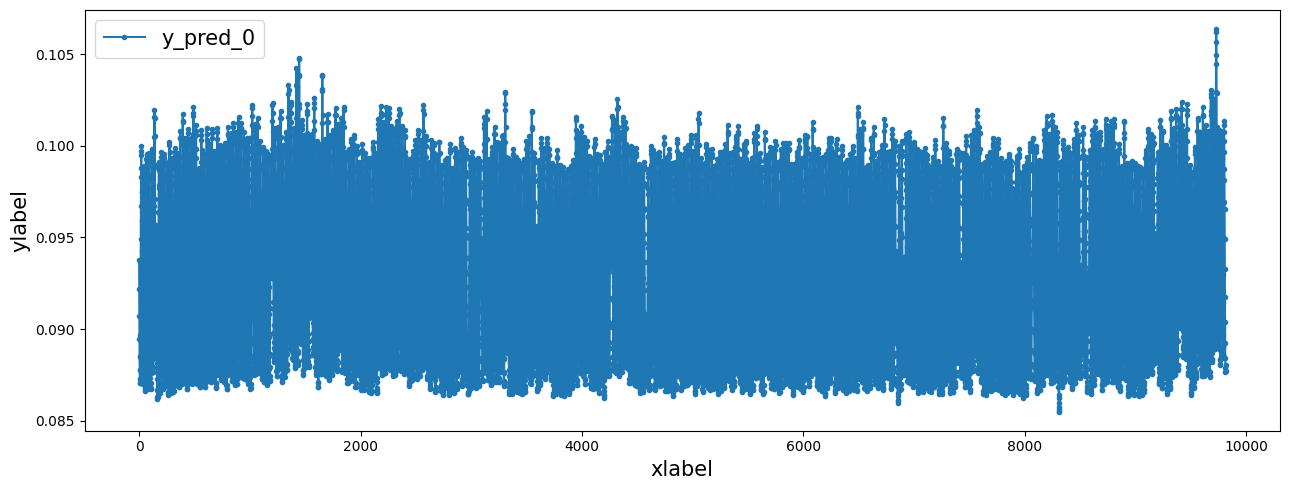

In [14]:
plot_1_data(data=y_pred[:, 0, :], datalabel="y_pred_0")

#### Shifted 1

Model: "lstms2s_shifted_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 168, 128)  │     71,168 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 64),      │     49,408 │ lstm_4[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 4, 32)     │          0 │ dense_2[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 4, 64)     │     24,832 │ repeat_vector_1[… │
│                     │                   │            │ lstm_5[0][1],     │
│                     │                   │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 4, 128)    │     98,816 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 1)      │        129 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


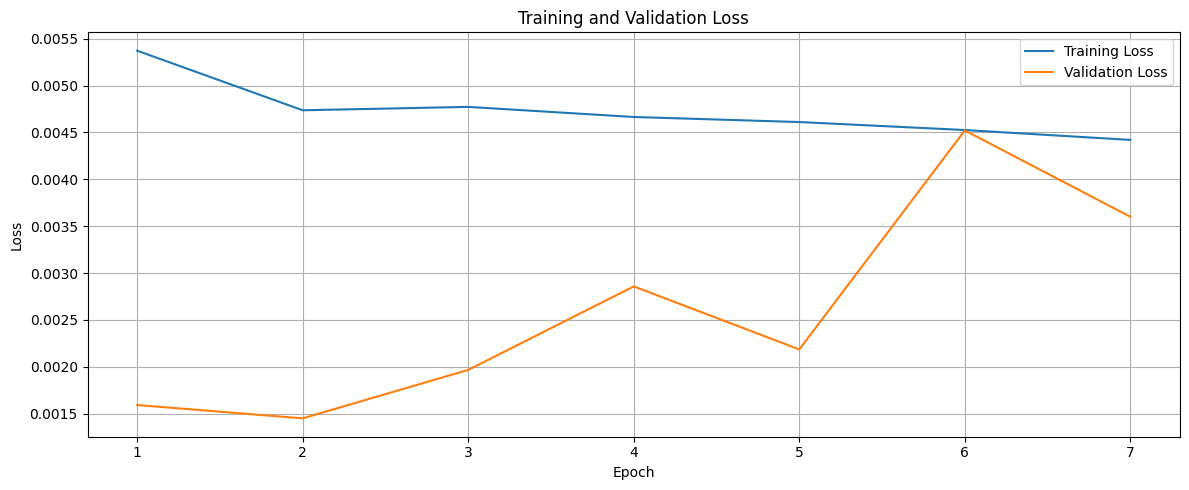

307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step
Day = 0
mae: 6.358011649274399
mse: 83.62693651945997
rmse: 9.14477646087973
r2: -2537.9506950826685
mape: 0.41135957236251236
mnbe: -19.989539173076455
r_coeff: [0.24371679]


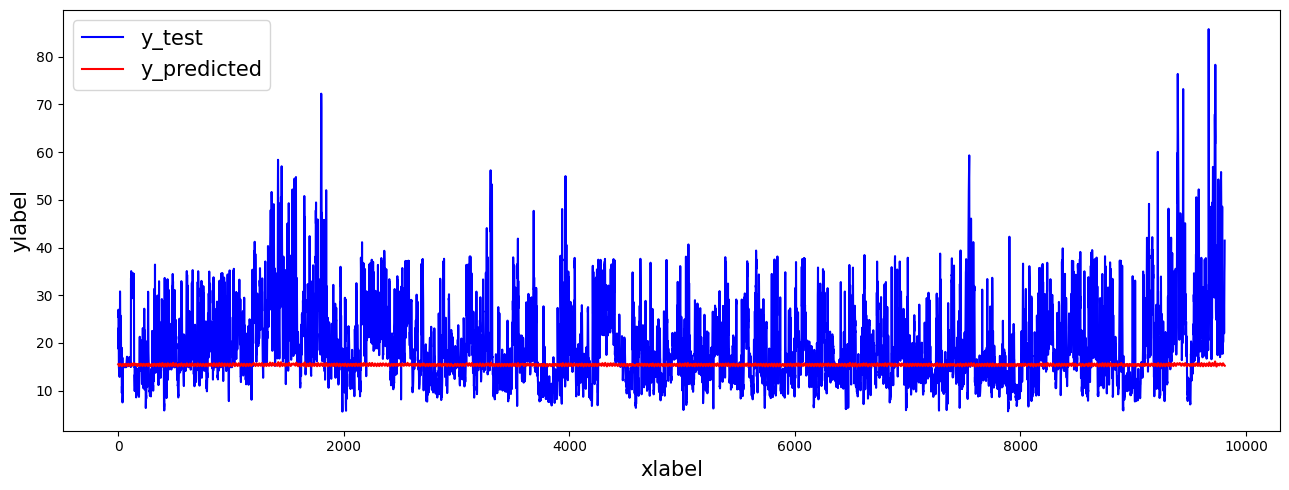

Day = 1
mae: 6.4008570212955
mse: 85.0675137094605
rmse: 9.223205175504907
r2: -3197.686728239704
mape: 0.4189852294234976
mnbe: -20.893684100492816
r_coeff: [0.24483564]


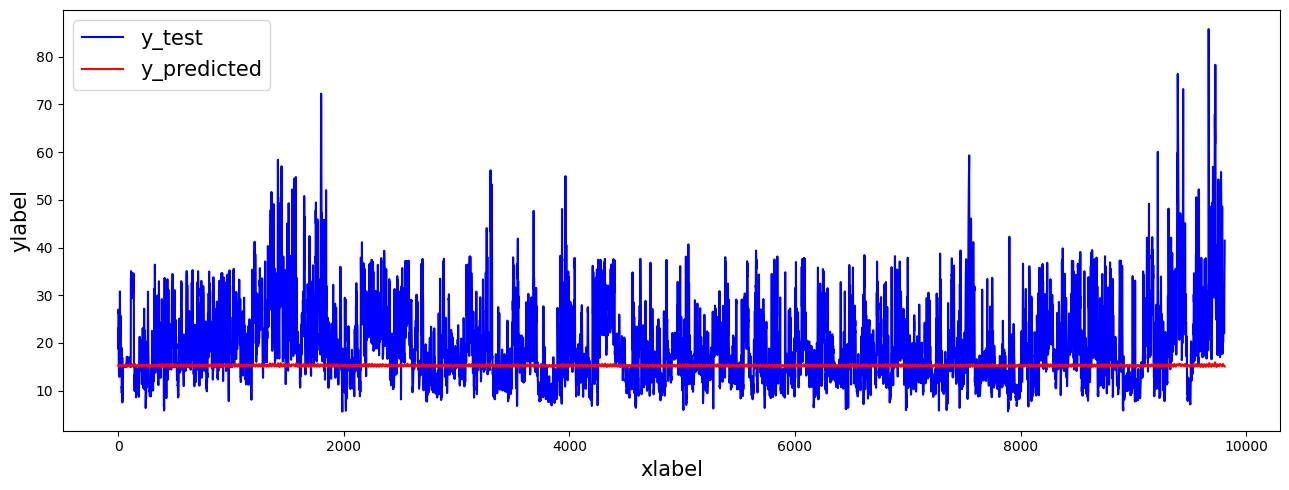

Day = 2
mae: 6.4818561959094
mse: 87.48919319828902
rmse: 9.353565801248688
r2: -5502.066394527063
mape: 0.4319433667834553
mnbe: -22.216406172846384
r_coeff: [0.16732304]


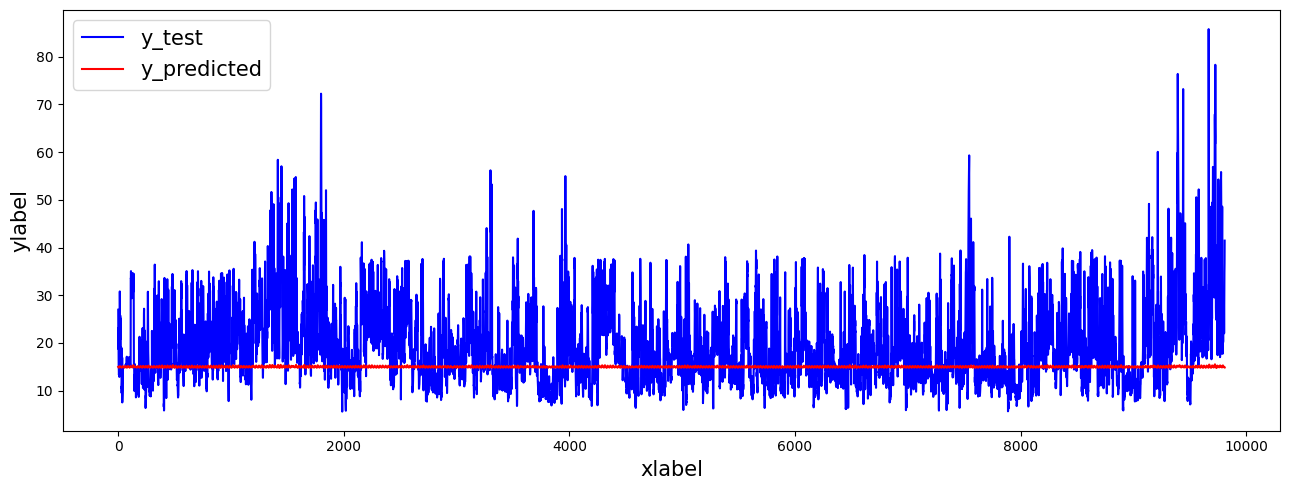

Day = 3
mae: 6.5396780631711975
mse: 89.12877723148655
rmse: 9.440803844561465
r2: -9164.867797385637
mape: 0.44081839204609585
mnbe: -23.022189111053265
r_coeff: [0.03604804]


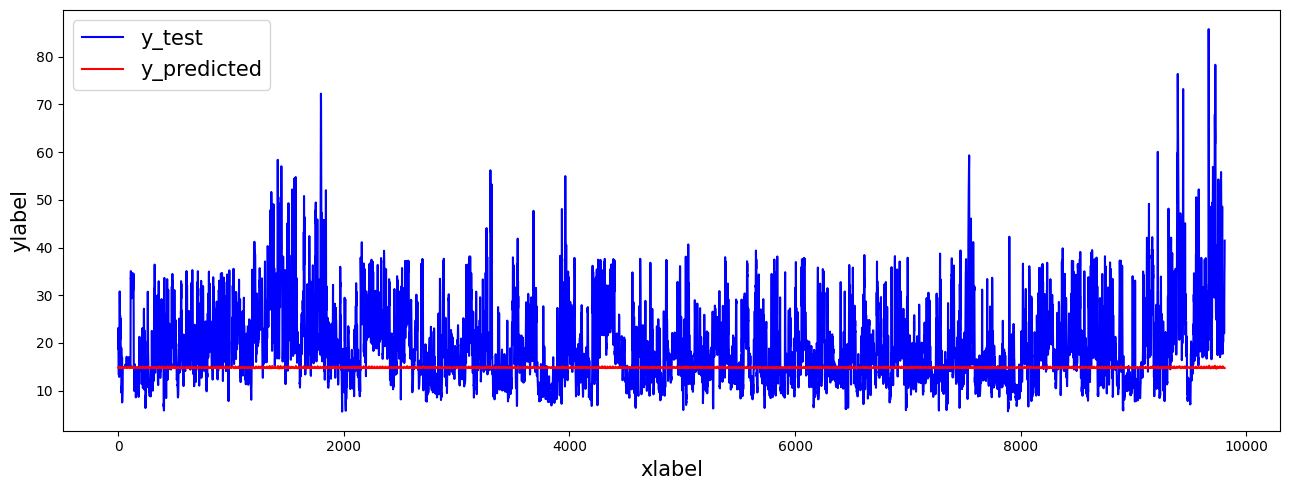

In [15]:
lstms2s_shifted_1 = define_lstms2s_model(n_past, n_future, X_train_shifted_1.shape[-1], y_train_shifted_1.shape[-1], "lstms2s_shifted_1")

history = lstms2s_shifted_1.fit(X_train_shifted_1, y_train_shifted_1,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_1 = lstms2s_shifted_1.predict(X_test_shifted_1)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_1[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_1[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 2

In [16]:
lstms2s_shifted_2 = define_lstms2s_model(n_past, n_future, X_train_shifted_2.shape[-1], y_train_shifted_2.shape[-1], "lstms2s_shifted_2")

history = lstms2s_shifted_2.fit(X_train_shifted_2, y_train_shifted_2,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_2 = lstms2s_shifted_2.predict(X_test_shifted_2)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_2[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_2[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

Model: "lstms2s_shifted_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 168, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 168, 128)  │     71,168 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 64),      │     49,408 │ lstm_8[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 4, 32)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_2[… │
│                     │                   │            │ lstm_9[0][1],     │
│                     │                   │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 4, 1)      │        129 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 246,433 (962.63 KB)

 Trainable params: 246,433 (962.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
108/249 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0074

KeyboardInterrupt: 

#### Shifted 3

In [ ]:
lstms2s_shifted_3 = define_lstms2s_model(n_past, n_future, X_train_shifted_3.shape[-1], y_train_shifted_3.shape[-1], "lstms2s_shifted_3")

history = lstms2s_shifted_3.fit(X_train_shifted_3, y_train_shifted_3,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_3 = lstms2s_shifted_3.predict(X_test_shifted_3)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_3[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_3[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 4

In [ ]:
lstms2s_shifted4 = define_lstms2s_model(n_past, n_future,  X_train_shifted_4.shape[-1], y_train_shifted_4.shape[-1], "lstms2s_shifted_4")

history = lstms2s_shifted4.fit(X_train_shifted_4, y_train_shifted_4,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_4 = lstms2s_shifted4.predict(X_test_shifted_4)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_4[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_4[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

### GRU-Seq2Seq

In [ ]:
def define_grus2s_model(n_past, n_future, n_features, n_label, name="model"):
    # encoder layers
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_gru_1 = GRU(128, return_sequences=True, activation="relu")(encoder_inputs)
    encoder_gru_2, state_h = GRU(64, return_state=True, activation="relu")(encoder_gru_1)
    encoder_dropout = Dropout(0.2)(encoder_gru_2)
    encoder_dense = Dense(latent_dim)(encoder_dropout)
    # Repeat layer
    decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
    # Decoder layers
    decoder_gru_1 = GRU(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=state_h)
    decoder_gru_2 = GRU(128, return_sequences=True, activation="relu")(decoder_gru_1)
    decoder_dropout = Dropout(0.2)(decoder_gru_2)
    decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
    # Compile the model
    model = Model(encoder_inputs, decoder_outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    display(model.summary())
    return model

#### No shift

In [ ]:
grus2s = define_grus2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], "grus2s_no_shift")

history = grus2s.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = grus2s.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 1

In [ ]:
grus2s_shifted1 = define_grus2s_model(n_past, n_future, X_train_shifted_1.shape[-1], y_train_shifted_1.shape[-1], "grus2s_shifted_1")

history = grus2s_shifted1.fit(X_train_shifted_1, y_train_shifted_1,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_1 = grus2s_shifted1.predict(X_test_shifted_1)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_1[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_1[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 2

In [ ]:
grus2s_shifted_2 = define_grus2s_model(n_past, n_future, X_train_shifted_2.shape[-1], y_train_shifted_2.shape[-1], "grus2s_shifted_2")

history = grus2s_shifted_2.fit(X_train_shifted_2, y_train_shifted_2,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_2 = grus2s_shifted_2.predict(X_test_shifted_2)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_2[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_2[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 3

In [ ]:
grus2s_shifted_3 = define_grus2s_model(n_past, n_future, X_train_shifted_3.shape[-1], y_train_shifted_3.shape[-1], "grus2s_shifted_3")

history = grus2s_shifted_3.fit(X_train_shifted_3, y_train_shifted_3,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_3 = grus2s_shifted_3.predict(X_test_shifted_3)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_3[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_3[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

#### Shifted 4

In [ ]:
grus2s_shifted4 = define_grus2s_model(n_past, n_future,  X_train_shifted_4.shape[-1], y_train_shifted_4.shape[-1], "grus2s_shifted_4")

history = grus2s_shifted4.fit(X_train_shifted_4, y_train_shifted_4,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred_shifted_4 = grus2s_shifted4.predict(X_test_shifted_4)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test_shifted_4[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred_shifted_4[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

In [ ]:
stop

### CNN-LSTM Seq2seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_cnn_1 = Conv1D(filters=128, kernel_size=2, activation="relu")(encoder_inputs)
encoder_max_pooling_1 = MaxPooling1D(pool_size=2)(encoder_cnn_1)
encoder_cnn_2 = Conv1D(filters=64, kernel_size=2, activation="relu")(encoder_max_pooling_1)
encoder_max_pooling_2 = MaxPooling1D(pool_size=2)(encoder_cnn_2)
encoder_lstm, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_max_pooling_2)
encoder_dropout = Dropout(0.2)(encoder_lstm)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_dropout = Dropout(0.2)(decoder_lstm_1)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
cnncnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
# Compile the model
cnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
cnnlstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(cnnlstms2smodel.summary())

# Fit model
history = cnnlstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    #EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = cnnlstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

## Evaluation board

In [ ]:
pd.DataFrame(evaluation_board)